In [99]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

In [44]:
data = pd.read_csv('WAG_C_M.csv', sep = ';', parse_dates=['month'], dayfirst=True, index_col=['month'])

In [45]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

## Визуальный анализ ряда

посмотрим на данные

Text(0.5,0,'month')

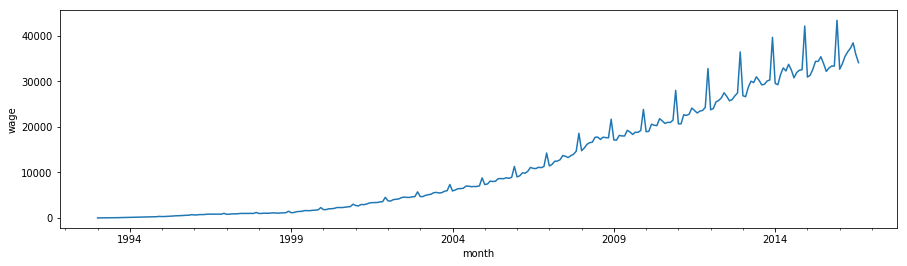

In [72]:
plt.figure(figsize = (15, 4))
data['WAG_C_M'].plot()
plt.ylabel('wage')
plt.xlabel('month')

на графике видим явный тренд на увеличение заработной платы, также можно отметить годовую сезонность изменений. Дисперсия ряда увеличивается с течением времени.
Очевидно, что гипотеза о стационарности на данный момент не будет принята, но тем не менее применим критерий Дики-Фуллера, просто потому, что мы можем (во имя науки, конечно же).

Критерий Дики-Фуллера: p=0.9918495954854735


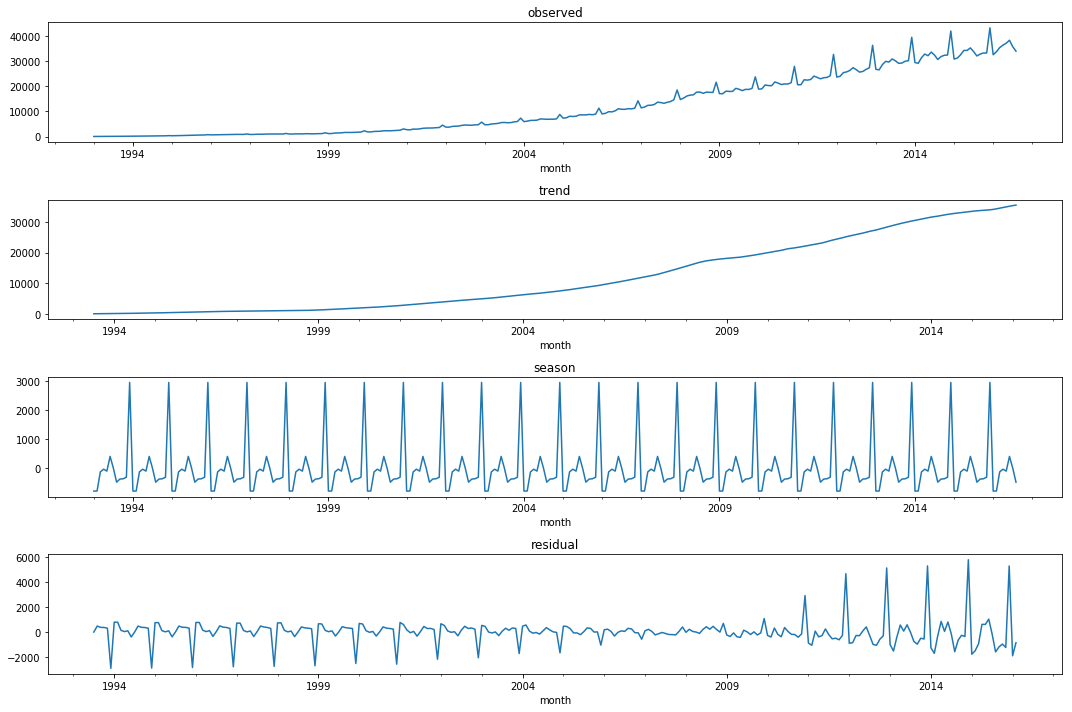

In [67]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize = (15,10))
sm.tsa.seasonal_decompose(data['WAG_C_M']).observed.plot(ax = ax0)
sm.tsa.seasonal_decompose(data['WAG_C_M']).trend.plot(ax = ax1)
sm.tsa.seasonal_decompose(data['WAG_C_M']).seasonal.plot(ax = ax2)
sm.tsa.seasonal_decompose(data['WAG_C_M']).resid.plot(ax = ax3)
print("Критерий Дики-Фуллера: p=" + str(sm.tsa.stattools.adfuller(data['WAG_C_M'])[1]))
ax0.set_title('observed')
ax1.set_title('trend')
ax2.set_title('season')
ax3.set_title('residual')
plt.tight_layout()

Как и ожидалось, критерий Дики-Фуллера не позволяет отвергнуть гипотезу о нестационарности. По графику сезонности можно еще раз убедиться, что она ярко выражена в имеющихся данных. Остатки сначала отрицательные, а затем положительные. Так как дисперсия не постоянная, попробуем ее стабилизировать методом Бокса-Кокса 

## Стабилизация дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


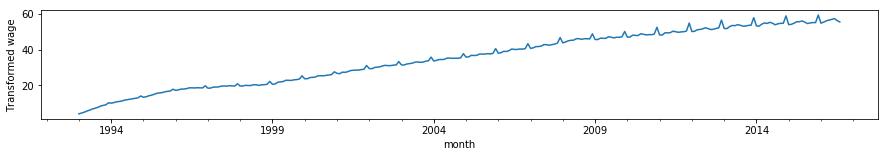

In [71]:
from scipy import stats
data['WAG_box'], lmbda = stats.boxcox(data['WAG_C_M'])
plt.figure(figsize = (15,2))
data['WAG_box'].plot()
plt.ylabel(u'Transformed wage')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['WAG_box'])[1])

видим, что диспресия стала более соизмеримой, и критерий Дики-Фулера также стал более близок к отвержению нулевой гипотезы о нестационарности. Но так как все равно между стационарным процессом и нашим - пропасть, процесс будем считать нестационарным и попытаемся его привести к стационарному с помощью дифференцирования. Начинать советовали с сезонного дифференцирования, мы воспользуемся этим советом.

## Выбор порядка дифференцирования

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

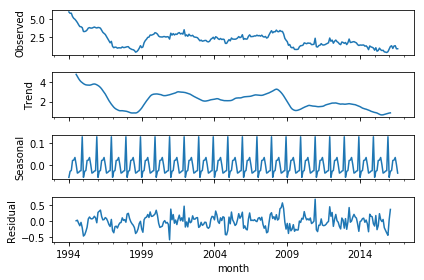

In [74]:
data['wage_box_diff'] = data['WAG_box'] - data['WAG_box'].shift(12)
plt.figure(figsize = (15,10))
sm.tsa.seasonal_decompose(data['wage_box_diff'][12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['wage_box_diff'][12:])[1])

тренд перестал быть возрастающим, но считать его константным пока рука не поднимается (он даже скорее убывающий теперь). Попробуем продифференцировать еще, на этот раз со сдвигом в месяц. (хотя формально значение 0.014697 позволяет отвергнуть гипотезу о нестационарности)

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

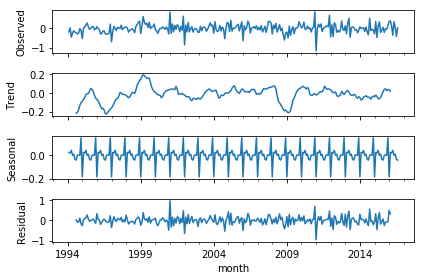

In [76]:
data['wage_box_diff2'] = data['wage_box_diff'] - data['wage_box_diff'].shift(1)
plt.figure(figsize = (15,10))
sm.tsa.seasonal_decompose(data['wage_box_diff2'][13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['wage_box_diff2'][13:])[1])

нуууу...такое. Формально по критерию можно уже бить кулаком в грудь и говорить, что процесс стационарен. Хотя лично меня все еще напрягают провалы в начале и после середины, но тенденции к увеличению или уменьшению нет, и колебания, хоть и большие, поисходят вокруг константы. Так что мы двинемся дальше

## Выбор начальных приближений для p, q, P, Qp,q,P,Q

Построим график автокорреляционной и частичной автокорреляционной функции дважды продифференцированного ряда

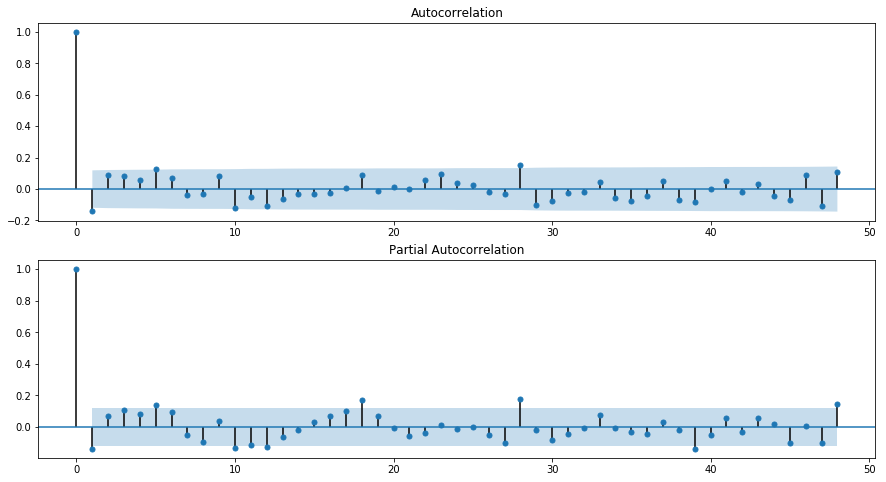

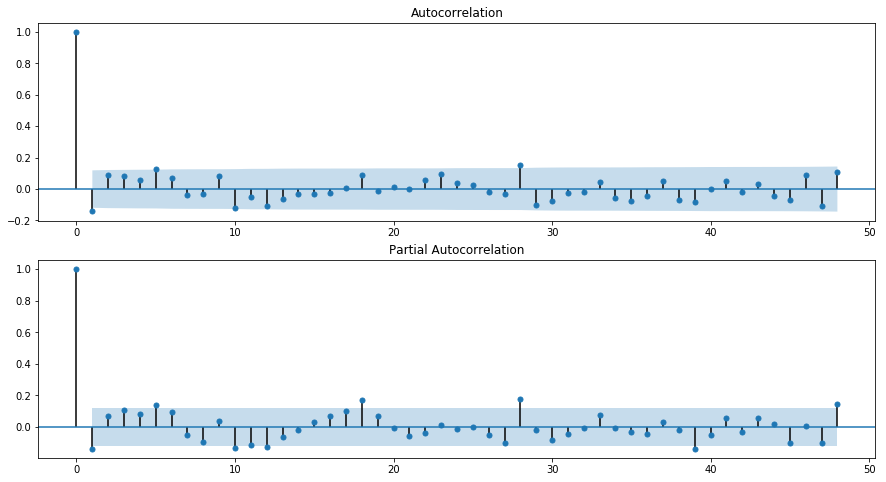

In [85]:
plt.figure(figsize = (15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['wage_box_diff2'][13:].values.squeeze(), lags=48, ax=ax)
ax1 = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['wage_box_diff2'][13:].values.squeeze(), lags=48, ax=ax1)

я не понимаю, почему графиков 4, а не 2. Но это не мешает нам продолжить.

По первому графику подбираются параметры Q и q. Значимый сезонный лаг только в точке лаг = 0. Так что Q = 0
А последний несезонный значимый лаг равен 28. Но здраввый смысл подсказывает, что значимость скорее всего объясняется множественной проверкой гипотез, так что я бы брала q  = 1.
По второму графику подбираются P и p. 48 лаг значим, а это при сезонности, равной 12, означает, что P = 4. Опять же из соображений адекватности значение p больше, чем S, вряд ли стоит брать. Так что в качестве p возьмем 10.

Итого:
    Q = 0
    q = 1
    P = 4
    p = 10

Теперь будем перебирать модели

## Обучение и сравнение моделей-кандидатов, выбор победителя

In [90]:
from itertools import product

ps = range(0, 11)
d=1
qs = range(0, 2)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

110

In [93]:
%%time
import warnings
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data['WAG_box'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 2, 0))
('wrong parameters:', (2, 1, 3, 0))
('wrong parameters:', (2, 1, 4, 0))
Wall time: 15min 31s


Посмотрим на полученные модели

In [94]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

        parameters       aic
56    (6, 0, 1, 0) -7.552970
101  (10, 1, 1, 0) -7.168053
57    (6, 0, 2, 0) -6.480323
59    (6, 0, 4, 0) -6.327815
100  (10, 1, 0, 0) -5.958379


Лучшая модель имеет параметры p = 6, q = 0, P = 1, Q = 0.

In [95]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            WAG_box   No. Observations:                  284
Model:             SARIMAX(6, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  11.776
Date:                            Fri, 02 Nov 2018   AIC                             -7.553
Time:                                    12:20:07   BIC                             21.264
Sample:                                01-01-1993   HQIC                             4.017
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1991      0.045     -4.401      0.000      -0.288      -0.110
ar.L2          0.0224      0.066   

По критерию Льюиса видим, что остатки не автокоррелированы, это хорошо. Посмотрим на остатки еще подробнее

Критерий Стьюдента: p=0.2931446031281608
Критерий Дики-Фуллера: p=2.480288039381587e-29


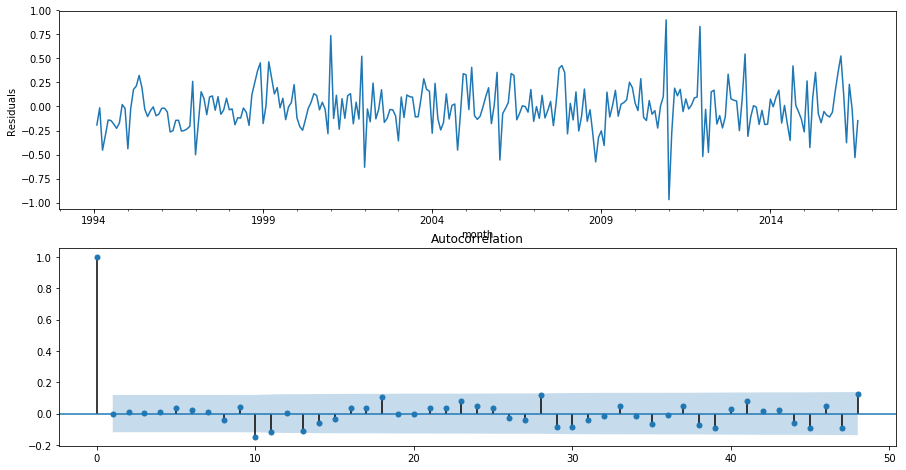

In [97]:
plt.figure(figsize = (15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=" + str(stats.ttest_1samp(best_model.resid[13:], 0)[1]))
print("Критерий Дики-Фуллера: p=" + str(sm.tsa.stattools.adfuller(best_model.resid[13:])[1]))

Остатки:  
несмещены (подтверждается критерием Стьюдента) - мы не можем отвергнуть гипотезу о равенстве 0 математического ожидания распределения остатков.  
стационарны (подтверждается критерием Дики-Фуллера и визуально) - вроде похоже на то, что какие бы участки распределения мы не рассматривали, параметры распределений на этих участках будут не сильно отличаться.  
неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). - фактически отсутствуют значимые отличия от нуля автокорреляций.  
Посмотрим, насколько хорошо модель описывает данные:

Text(0,0.5,'Wage')

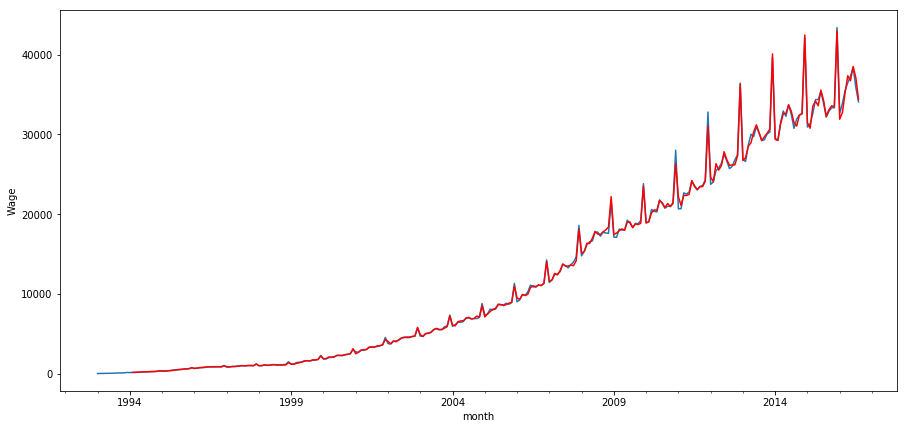

In [140]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize = (15,7))
data['WAG_C_M'].plot()
data['model'][13:].plot(color='r')
plt.ylabel('Wage')

## Прогноз

спрогнозируем зарплату на 3 года вперед

Text(0,0.5,'Wage')

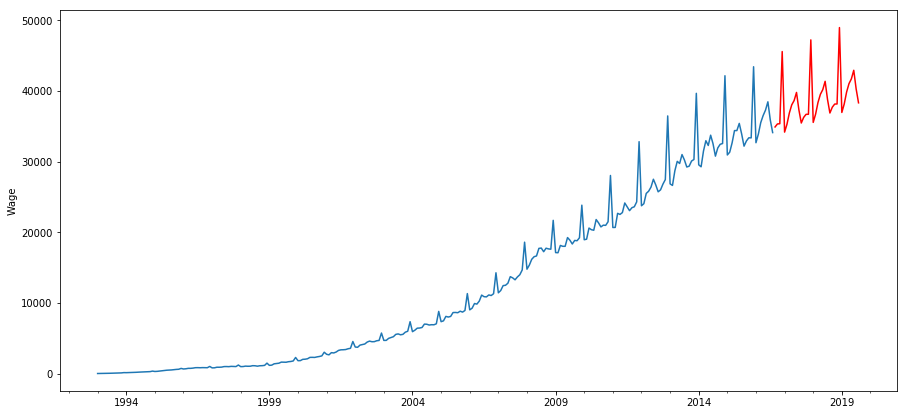

In [139]:
import datetime
from dateutil import relativedelta

wage = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta.relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= wage.columns)
wage = pd.concat([wage, future])
wage['forecast'] = invboxcox(best_model.predict(start=284, end=319), lmbda)

plt.figure(figsize = (15,7))
wage['WAG_C_M'].plot()
wage.forecast.plot(color='r')
plt.ylabel('Wage')

выглядит похожим на правду и логичным: сохраняется сезонность, как и в данных, на которых мы обучались, также сохраняется тренд